# Aula 7 - VAEs - Variational Auto Encoders

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import random

In [2]:
# Use randomseed para resultados mais consistentes
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # flag presente no tf 2.0+
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
from tensorflow.keras.datasets import fashion_mnist


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape)
print(x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


<h2>Available Labels/Classes in Fashion Mnist dataset</h2>

<table align="left">
<thead>
<tr>
<th align="center">Label</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td align="center">0</td>
<td>T-shirt/top</td>
</tr>
<tr>
<td align="center">1</td>
<td>Trouser</td>
</tr>
<tr>
<td align="center">2</td>
<td>Pullover</td>
</tr>
<tr>
<td align="center">3</td>
<td>Dress</td>
</tr>
<tr>
<td align="center">4</td>
<td>Coat</td>
</tr>
<tr>
<td align="center">5</td>
<td>Sandal</td>
</tr>
<tr>
<td align="center">6</td>
<td>Shirt</td>
</tr>
<tr>
<td align="center">7</td>
<td>Sneaker</td>
</tr>
<tr>
<td align="center">8</td>
<td>Bag</td>
</tr>
<tr>
<td align="center">9</td>
<td>Ankle boot</td>
</tr>
</tbody>
</table>

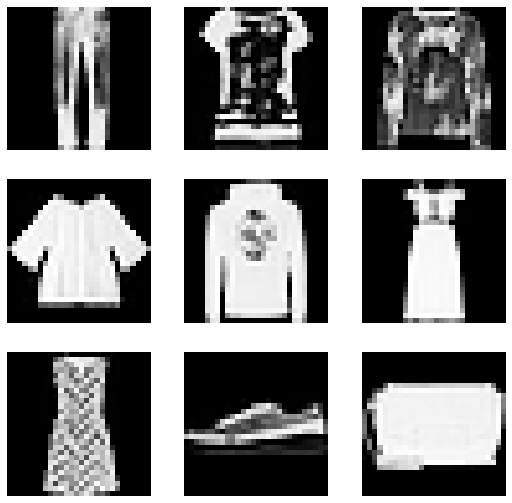

In [4]:
plt.figure(figsize=(9, 9))

# Escolhendo 9 amostras de 60K disponíveis no conjunto de treino
rndSamples = np.random.choice(60000, 9)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[rndSamples[i]], cmap="Greys_r")
    plt.axis('off')

plt.show();

In [5]:
dataset = np.concatenate([x_train, x_test], axis=0)
# Converte imagens de 28x28 para 28x28x1 como camadas convolucionais esperam 3 canais
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

In [6]:
from tensorflow import keras
from tensorflow.keras import layers


# Crie uma camada de amostragem onde definimos a reparametrização
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [7]:
def buildEncoder(latentDim, encoderInputs):

# Dado um batch de imagens, o bloco convolucional extrai os recursos
  l1 = keras.models.Sequential([
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])

#passa as entradas pelo bloco convolucional
  x = l1(encoderInputs)

# uma camada dedicada para aprender a média em paralelo
  zMean = layers.Dense(latentDim, name="z_mean")(x)

# uma camada dedicada para aprender a variação em paralelo
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

# agora o truque de reparametrização para encontrar z como definido por média e variância
  z = SamplingLayer()([zMean, zLogVar])

  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")


# aciona a função para realmente construir o modelo
encoderInputs = keras.Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 256)          878144      ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['sequential[0][0]']             
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['sequential[0][0]']             
                                                                                            

In [8]:
def buildDecoder(latentInputs):

  l1 = keras.models.Sequential([
    layers.Dense(7*7*64, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((7,7,64)),
    layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
  ])

  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

# construindo o modelo real
latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         157633    
                                                                 
Total params: 157,633
Trainable params: 157,633
Non-trainable params: 0
_________________________________________________________________


## Funções de perda (loss)


In [9]:
# A função de primeira perda é a perda de reconstrução, que penaliza imagens que não sejam semelhantes às imagens originais.

def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),
          axis=(1, 2)
      )
  )

In [10]:
# Função de perda de divergência de Kullback-Liebler que penaliza o modelo se ele aprender
# uma distribuição de probabilidade "z" diferente da distribuição de probabilidade original dos dados "X".

def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
          axis=1
      )
  )

In [11]:
# Agora vamos combiná-los na função de perda total

def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

In [12]:
# Como estamos usando uma função de perda personalizada em mu e sigma, precisamos substituir como a perda é calculada.
# Precisamos comparar X_original e X_reconstructed ao mesmo tempo enquanto calculamos a perda de Kullback-Liebler (KL).

class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    # registra a perda total como uma métrica observável no histórico de treinamento do modelo
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")
    
  # Todas sendo métricas observáveis 
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  # Agora calcule a perda + calcule os gradientes + atualize os pesos
  def train_step(self, data):
    # A fita de gradiente é uma gravação de todos os gradientes para o treinável
    # pesos que precisam ser atualizados
    with tf.GradientTape() as tape:

 # caminho para frente
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)
        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
 
 # caminho para trás
 
    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

# acompanhando a perda

    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

# retorna a perda do objeto histórico

    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

## Treinando o modelo

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(dataset, epochs=32, batch_size=128)

Epoch 1/32
547/547 [==============================] - 25s 16ms/step - total_loss: 310.9017 - ce_loss: 299.4895 - kl_loss: 3.8040
Epoch 2/32
547/547 [==============================] - 9s 16ms/step - total_loss: 278.0734 - ce_loss: 264.3748 - kl_loss: 4.5663
Epoch 3/32
547/547 [==============================] - 8s 15ms/step - total_loss: 274.8810 - ce_loss: 260.7900 - kl_loss: 4.6970
Epoch 4/32
547/547 [==============================] - 9s 16ms/step - total_loss: 273.3067 - ce_loss: 259.0411 - kl_loss: 4.7553
Epoch 5/32
547/547 [==============================] - 9s 16ms/step - total_loss: 272.2475 - ce_loss: 257.7941 - kl_loss: 4.8178
Epoch 6/32
547/547 [==============================] - 9s 16ms/step - total_loss: 271.3860 - ce_loss: 256.8387 - kl_loss: 4.8490
Epoch 7/32
547/547 [==============================] - 9s 16ms/step - total_loss: 270.8379 - ce_loss: 256.1680 - kl_loss: 4.8899
Epoch 8/32
547/547 [==============================] - 9s 16ms/step - total_loss: 270.4730 - ce_loss: 25

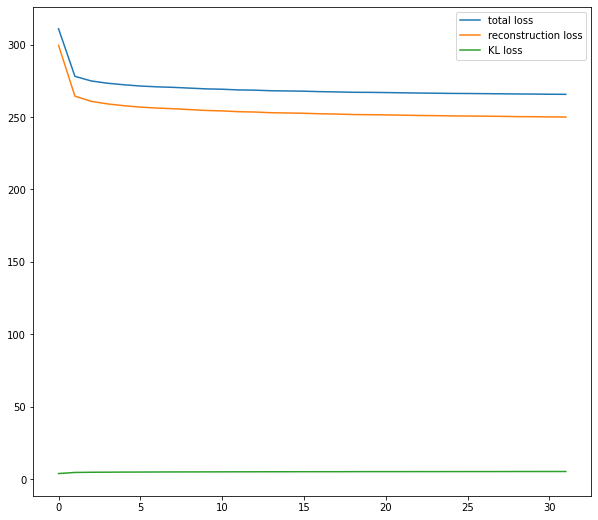

In [14]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

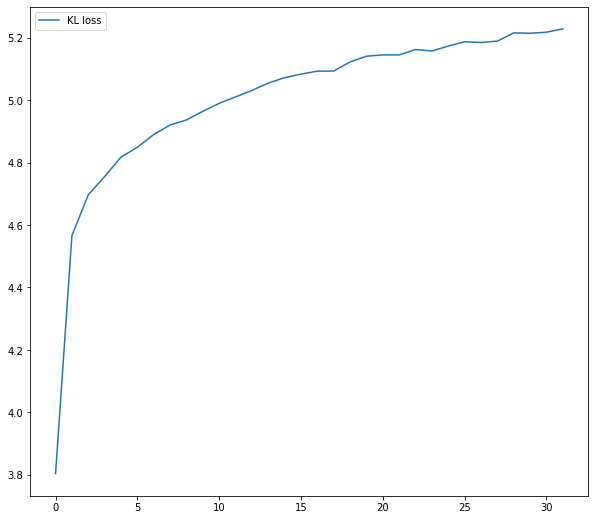

In [15]:
# Vamos ampliar a perda de KL para que possamos ver melhor

plt.figure(figsize=(10, 9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

# Resultados


1/1 [==============================] - 0s 156ms/step


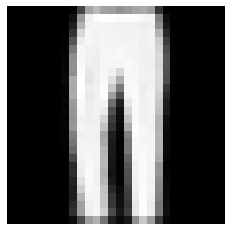

In [16]:
# use uma média (mu) de 1 e variância (sigma) de 2 (apenas um palpite para começarmos)

synth = vae.decoder.predict([[1, 2]])
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r");

4/4 [==============================] - 0s 8ms/step


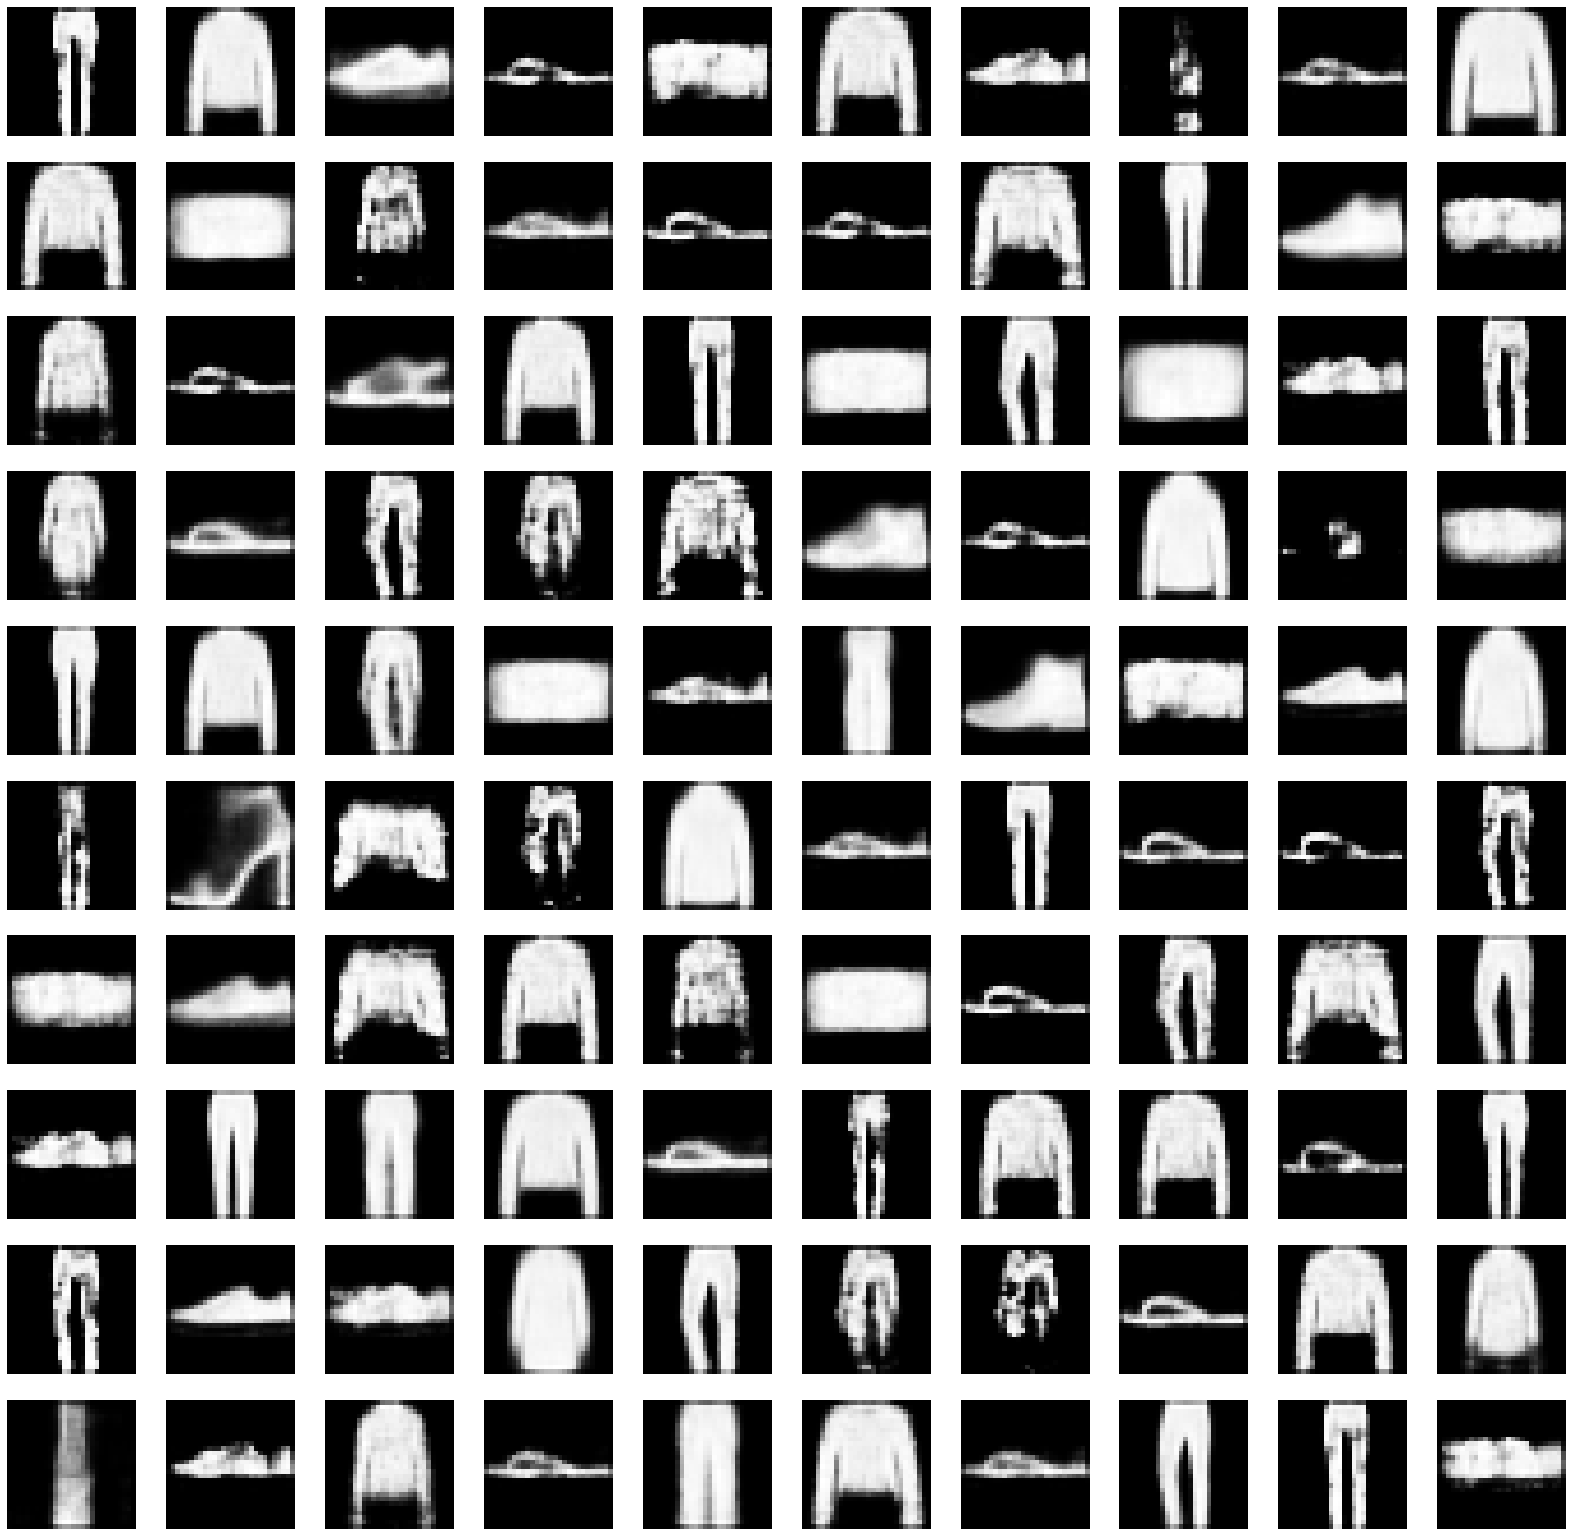

In [17]:
z = np.random.normal(loc=0, scale=4, size=(100,2))
synth = vae.decoder.predict(z)

plt.figure(figsize=(28,28))

for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
    plt.axis('off')

plt.show();

In [18]:
# Mapearemos uma imagem de uma categoria através do codificador e observaremos a saída.
# Em seguida, usaremos essas saídas para instruir condicionalmente o decodificador a amostrar de uma categoria específica.

idx = 1280 # arbitrariamente
batch = np.expand_dims(x_train[idx], axis=0)
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255
print(batchOfImages.shape)

# obtém z(mu,sigma) para a imagem dada
_, _, z = vae.encoder.predict(batchOfImages)

# agora reconstrua uma imagem semelhante
synth = vae.decoder.predict([z])

z

(1, 28, 28, 1)
1/1 [==============================] - 0s 92ms/step


array([[1.0365319 , 0.81319445]], dtype=float32)

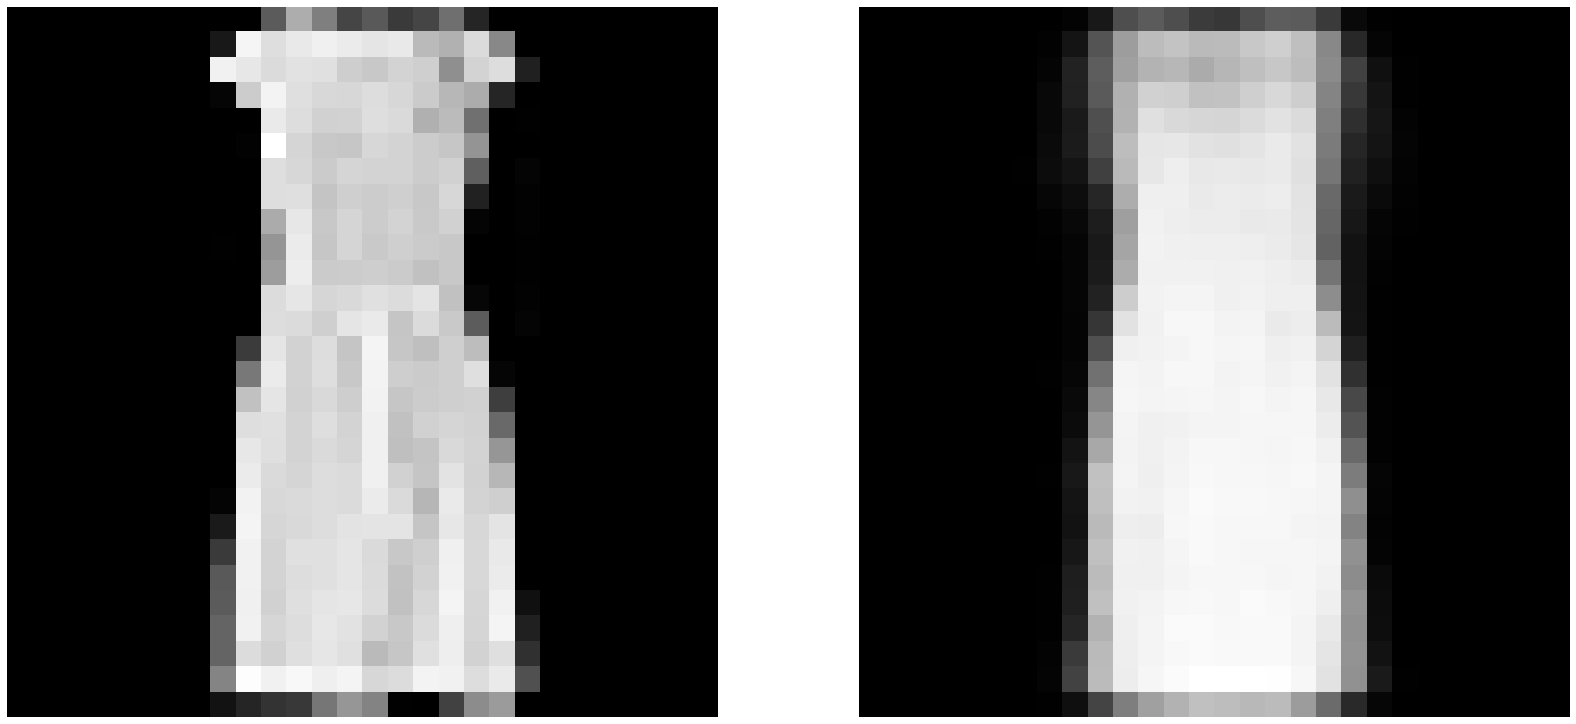

In [19]:
plt.figure(figsize=(28, 28))

# imagem original
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap="Greys_r")

# imagem reconstruída
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap="Greys_r")
plt.show();

2188/2188 [==============================] - 4s 2ms/step


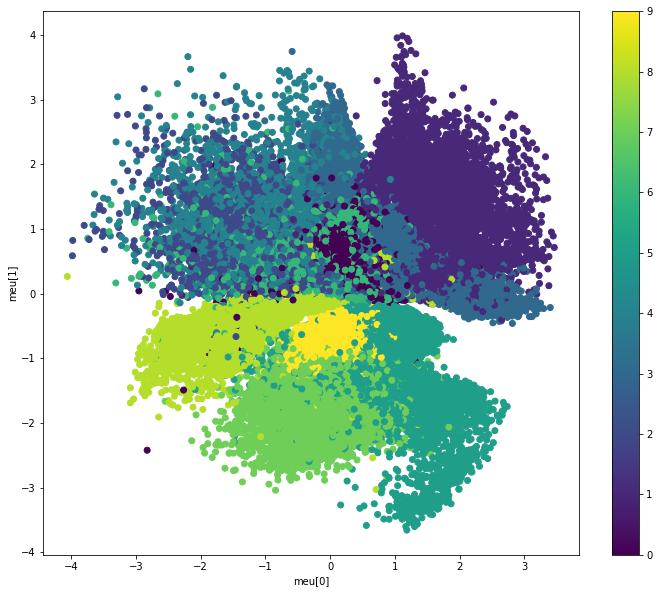

In [20]:
"""
O VAE pode ser usado no aprendizado não supervisionado de texto grande ou corpus de imagens não rotuladas
agrupar as amostras em categorias
"""

labels = np.concatenate([y_train, y_test], axis=0)
meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(12, 10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.colorbar()
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
plt.show();